# Customer Segmentation BDA Project - Part 2

## Clustering

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import year, max as spark_max, lit, col
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as F
from pyspark.sql.window import Window


In [0]:
df = spark.read.csv("dbfs:/FileStore/tables/marketing_campaign_preprocess.csv", header=True, inferSchema=True)
df.show()


+----------+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+-----------------+--------+-------------+-----------------------+------------------+---+
|Year_Birth| Education|Marital_Status| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|Total_Spend|NumTotalPurchases|Children|Days_Customer|AcceptedCampaigns_Total|Website_Engagement|Age|
+----------+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+---------

In [0]:
df.printSchema()

root
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: double (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedCmp5: integer (nullable = true)
 |-- AcceptedCmp1: integer (nullable = true)
 |-

# K-means

### Clustering #1
Clustering customers by Income, Age, Total_Spend, NumTotalPurchases: representing the relation between Income and Spending Behavior

In [0]:
# Define features
customer_value_columns = [
    'Income',
    'Age',
    'Total_Spend',
    'NumTotalPurchases'
]

# Assemble features
customer_value_assembler = VectorAssembler(
    inputCols=customer_value_columns,
    outputCol='customerValueFeatures'
)

# Scale features
customer_value_scaler = StandardScaler(
    inputCol='customerValueFeatures',
    outputCol='customerValueScaledFeatures',
    withStd=True,
    withMean=True
)

In [0]:
# Build pipeline
customer_value_pipeline = Pipeline(stages=[
    customer_value_assembler,
    customer_value_scaler
])

# Fit and transform
customer_value_pipeline_model = customer_value_pipeline.fit(df)
customer_value_df_prepared = customer_value_pipeline_model.transform(df)

##### Choosing K-value

In [0]:
# Loop to test different k values
k_values = list(range(2, 11))  # k from 2 to 10
silhouette_scores = []

for k in k_values:
    print(f"Training K-Means with k={k} ...")
    
    # Define K-Means model
    kmeans = KMeans(featuresCol='customerValueScaledFeatures', k=k, seed=42)
    
    # Fit model
    model = kmeans.fit(customer_value_df_prepared)
    
    # Transform data
    predictions = model.transform(customer_value_df_prepared)
    
    # Evaluate silhouette score
    evaluator = ClusteringEvaluator(featuresCol='customerValueScaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predictions)
    
    # Store result
    silhouette_scores.append(silhouette)
    
    print(f"Silhouette score for k={k}: {silhouette:.4f}")

print("Done!")


Training K-Means with k=2 ...
Silhouette score for k=2: 0.6086
Training K-Means with k=3 ...
Silhouette score for k=3: 0.4806
Training K-Means with k=4 ...
Silhouette score for k=4: 0.4384
Training K-Means with k=5 ...
Silhouette score for k=5: 0.4576
Training K-Means with k=6 ...
Silhouette score for k=6: 0.4164
Training K-Means with k=7 ...
Silhouette score for k=7: 0.3980
Training K-Means with k=8 ...
Silhouette score for k=8: 0.4631
Training K-Means with k=9 ...
Silhouette score for k=9: 0.4487
Training K-Means with k=10 ...
Silhouette score for k=10: 0.4424
Done!


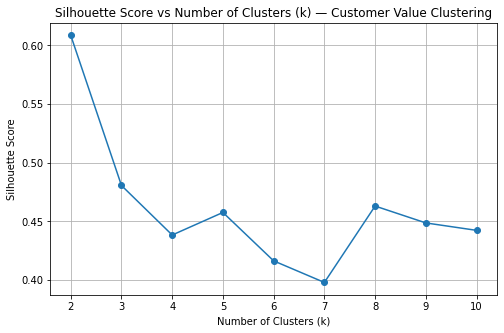

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters (k) — Customer Value Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

##### Apply k-means with best k (k=2)

In [0]:
# Run final K-Means with k = 2
k = 2
customer_value_kmeans = KMeans(featuresCol='customerValueScaledFeatures', k=k, seed=42)
customer_value_kmeans_model = customer_value_kmeans.fit(customer_value_df_prepared)
customer_value_predictions = customer_value_kmeans_model.transform(customer_value_df_prepared)

# Prepare for profiling
customer_value_clusters = customer_value_predictions
customer_value_clusters.cache()

# Show cluster sizes
customer_value_clusters.groupBy('prediction').count().orderBy('prediction').show()


+----------+-----+
|prediction|count|
+----------+-----+
|         0| 1047|
|         1| 1169|
+----------+-----+



##### Customer value clustering profiling

In [0]:
# columns to profile
customer_value_profile_columns = [
    'Income',
    'Age',
    'Total_Spend',
    'NumTotalPurchases',
    'Recency',
    'Website_Engagement',
]

In [0]:
# build aggregation expressions
customer_value_agg_exprs = [ F.avg(col).alias(f'avg_{col}') for col in customer_value_profile_columns ]

In [0]:
# compute cluster profile
customer_value_profile = customer_value_clusters.groupBy('prediction').agg(*customer_value_agg_exprs).orderBy('prediction')

# show profile
customer_value_profile.show(truncate=False)

+----------+-----------------+------------------+------------------+---------------------+-----------------+----------------------+
|prediction|avg_Income       |avg_Age           |avg_Total_Spend   |avg_NumTotalPurchases|avg_Recency      |avg_Website_Engagement|
+----------+-----------------+------------------+------------------+---------------------+-----------------+----------------------+
|0         |70398.76122254059|47.576886341929324|1135.8424068767908|21.499522445081183   |49.31041069723018|9.934097421203438     |
|1         |35990.08212147134|43.032506415739945|133.49187339606502|8.95295124037639     |48.74593669803251|8.929854576561164     |
+----------+-----------------+------------------+------------------+---------------------+-----------------+----------------------+



In [0]:
# convert to pandas to help visualizing
customer_value_profile_pd = customer_value_profile.toPandas()
pd.options.display.float_format = '{:,.2f}'.format
customer_value_profile_pd

,prediction,avg_Income,avg_Age,avg_Total_Spend,avg_NumTotalPurchases,avg_Recency,avg_Website_Engagement
0,0,"70,398.76",47.58,"1,135.84",21.50,49.31,9.93
1,1,"35,990.08",43.03,133.49,8.95,48.75,8.93


#### Clustering Analysis
**1. Income vs Spending**

Cluster 0 -> high income (70k) -> high spender (1135€) -> high purchase frequency (21.5 purchases).

Cluster 1 -> low income (36k) -> low spender (133€) → low purchase frequency (9 purchases).

Clear pattern -> higher income customers spend much more -> and buy more frequently.

**2. Age**

Cluster 0 → avg age ~47.6 years.

Cluster 1 → avg age ~43.0 years.

Slightly older customers in high income / high spend cluster.

-> Could indicate that older customers tend to have more purchasing power.

**3. Recency**

Both clusters have similar Recency.

-> No major difference in how recent their last purchase was. Both clusters are equally "active".

**4. Website Engagement**

Cluster 0 → avg Website Engagement ~9.93.

Cluster 1 → avg Website Engagement ~8.93.

Slightly higher online activity for the high spenders.

Suggests that both segments use the website, but higher income customers engage a little more online.

### Clustering #2
Clustering customers by buying behavior (types of products bought) with profiling on demographics

In [0]:
# Define features for clustering (product types)
product_purchase_columns = [
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds'
]

# Assemble the features
product_purchase_assembler = VectorAssembler(
    inputCols=product_purchase_columns,
    outputCol='productPurchaseFeatures'
)

# Scale the features
product_purchase_scaler = StandardScaler(
    inputCol='productPurchaseFeatures',
    outputCol='productPurchaseScaledFeatures',
    withStd=True,
    withMean=True
)

In [0]:
# Build pipeline
product_purchase_pipeline = Pipeline(stages=[
    product_purchase_assembler,
    product_purchase_scaler
])

# Fit and transform
product_purchase_pipeline_model = product_purchase_pipeline.fit(df)
product_purchase_df_prepared = product_purchase_pipeline_model.transform(df)

##### Choosing K value

In [0]:
# Loop to test different k values for product purchase clustering
product_purchase_k_values = list(range(2, 11))
product_purchase_silhouette_scores = []
product_purchase_wcss = []

for k in product_purchase_k_values:
    print(f"Training K-Means with k={k} ...")
    
    kmeans_tmp = KMeans(featuresCol='productPurchaseScaledFeatures', k=k, seed=42)
    model_tmp = kmeans_tmp.fit(product_purchase_df_prepared)
    predictions_tmp = model_tmp.transform(product_purchase_df_prepared)
    
    evaluator_tmp = ClusteringEvaluator(featuresCol='productPurchaseScaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator_tmp.evaluate(predictions_tmp)
    
    product_purchase_silhouette_scores.append(silhouette)
    
    print(f"Silhouette score for k={k}: {silhouette:.4f}")

print("Done!")

Training K-Means with k=2 ...
Silhouette score for k=2: 0.6406
Training K-Means with k=3 ...
Silhouette score for k=3: 0.5636
Training K-Means with k=4 ...
Silhouette score for k=4: 0.5409
Training K-Means with k=5 ...
Silhouette score for k=5: 0.5475
Training K-Means with k=6 ...
Silhouette score for k=6: 0.5419
Training K-Means with k=7 ...
Silhouette score for k=7: 0.4723
Training K-Means with k=8 ...
Silhouette score for k=8: 0.5007
Training K-Means with k=9 ...
Silhouette score for k=9: 0.5892
Training K-Means with k=10 ...
Silhouette score for k=10: 0.4968
Done!


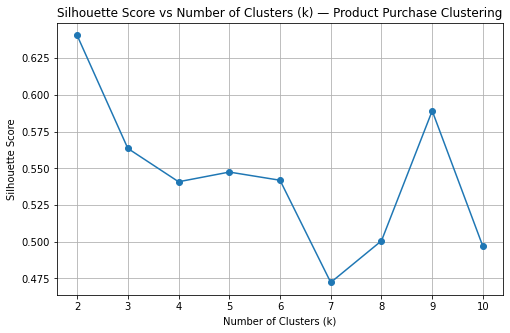

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(product_purchase_k_values, product_purchase_silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters (k) — Product Purchase Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

##### Apply k-means with chosen k (k=3)

In [0]:
# Final K-Means with k = 3 for product purchase clustering
k = 3
product_purchase_kmeans = KMeans(featuresCol='productPurchaseScaledFeatures', k=k, seed=42)
product_purchase_kmeans_model = product_purchase_kmeans.fit(product_purchase_df_prepared)
product_purchase_predictions = product_purchase_kmeans_model.transform(product_purchase_df_prepared)

# Prepare for profiling
product_purchase_clusters = product_purchase_predictions
product_purchase_clusters.cache()

# Show cluster sizes
product_purchase_clusters.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  552|
|         1| 1294|
|         2|  370|
+----------+-----+



##### Customer value clustering profiling

In [0]:
# numeric columns to profile
product_purchase_numeric_columns = [
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds',
    'Age',
    'Children'
]

In [0]:
# Build aggregation expressions
product_purchase_agg_exprs = [ F.avg(col).alias(f'avg_{col}') for col in product_purchase_numeric_columns ]

# Compute cluster profile for numeric columns
product_purchase_profile = product_purchase_clusters.groupBy('prediction').agg(*product_purchase_agg_exprs).orderBy('prediction')

In [0]:
# convert to pandas for better visualization
product_purchase_profile_pd = product_purchase_profile.toPandas()
pd.options.display.float_format = '{:,.2f}'.format
product_purchase_profile_pd

,prediction,avg_MntWines,avg_MntFruits,avg_MntMeatProducts,avg_MntFishProducts,avg_MntSweetProducts,avg_MntGoldProds,avg_Age,avg_Children
0,0,652.89,31.58,292.89,44.63,30.12,73.73,47.46,0.66
1,1,94.99,6.44,35.31,9.07,6.41,18.62,44.14,1.24
2,2,521.02,88.23,439.74,127.12,94.51,88.20,45.41,0.34


%md
#### Clustering Analysis
**Cluster 0**

-> Very high Wine spending → 652.89.

-> Also high Meat (292.89) and Gold Products (73.73).

-> Low on Fruits, Fish, Sweets: more "luxury" spending.

-> Avg Age 47.46; slightly older customers.

-> Children 0.66; fewer children.


**Cluster 1**

-> Very low spending across all categories; "low-value" or "basic buyers".

-> MntWines = 94.99; very low.

-> Low on Fruits, Fish, Sweets: more "luxury" spending.

-> Avg Age 44.14.

-> Children 1.24: higher, families with children.

**Cluster 2**

-> High spenders on everything: Wines = 521.02; Fruits = 88.23; 

Meat = 439.74; Fish = 127.12; Sweets = 94.51; GoldProds = 88.20

-> Age = 45.41 - slightly younger than Cluster 0, older than Cluster 1.

-> Children = 0.34 - few children.

In [0]:
# Education % per cluster

# Count Education per cluster
education_counts = product_purchase_clusters.groupBy('prediction', 'Education').count()

# Compute total per cluster
education_totals = product_purchase_clusters.groupBy('prediction').count().withColumnRenamed('count', 'total')

# Join totals back
education_counts = education_counts.join(education_totals, on='prediction')

# Compute percentage
education_counts = education_counts.withColumn('percentage', F.col('count') / F.col('total') * 100)

# Marital_Status % per cluster

# count Marital_Status per cluster
marital_counts = product_purchase_clusters.groupBy('prediction', 'Marital_Status').count()

# Compute total per cluster
marital_totals = product_purchase_clusters.groupBy('prediction').count().withColumnRenamed('count', 'total')

# Join totals back
marital_counts = marital_counts.join(marital_totals, on='prediction')

# Compute percentage
marital_counts = marital_counts.withColumn('percentage', F.col('count') / F.col('total') * 100)


In [0]:
# Convert Education % to pandas
education_counts_pd = education_counts.toPandas()
pd.options.display.float_format = '{:,.2f}'.format

# Sort by prediction and percentage descending
education_counts_pd = education_counts_pd.sort_values(by=['prediction', 'percentage'], ascending=[True, False])
#print
education_counts_pd


,prediction,Education,count,total,percentage
12,0,Graduation,258,552,46.74
2,0,PhD,163,552,29.53
3,0,Master,96,552,17.39
4,0,2n Cycle,34,552,6.16
5,0,Basic,1,552,0.18
13,1,Graduation,620,1294,47.91
7,1,PhD,273,1294,21.10
8,1,Master,226,1294,17.47
0,1,2n Cycle,123,1294,9.51
14,1,Basic,52,1294,4.02


#### Clustering Analysis
**Cluster 0**

Well-educated cluster:

-> 93.66% have at least Graduation or higher; very high education level.

-> Dominated by Graduation + PhD + Master.

-> Very small % of Basic or 2n Cycle.

**Cluster 1**

Also well-educated, but slightly more diverse:

-> Higher % of Basic (4.02%) and 2nd Cycle.

-> More spread out: supports the idea this cluster contains a broader demographic, including more families, as we saw in Children.

**Cluster 2**

Dominated by Graduation - very clear.

-> Also relatively well-educated, but less PhD than Cluster 0.

-> Almost no Basic education.

-> Children = 0.34 - few children.

In [0]:
# Convert Marital_Status % to pandas
marital_counts_pd = marital_counts.toPandas()
pd.options.display.float_format = '{:,.2f}'.format

# Sort by prediction and percentage descending
marital_counts_pd = marital_counts_pd.sort_values(by=['prediction', 'percentage'], ascending=[True, False])
marital_counts_pd

,prediction,Marital_Status,count,total,percentage
3,0,Married,212,552,38.41
12,0,Together,147,552,26.63
5,0,Single,108,552,19.57
15,0,Divorced,66,552,11.96
10,0,Widow,19,552,3.44
0,1,Married,510,1294,39.41
16,1,Together,334,1294,25.81
13,1,Single,276,1294,21.33
14,1,Divorced,131,1294,10.12
2,1,Widow,38,1294,2.94


#### Clustering Analysis
**Cluster 0**

-> Mostly Married + Together = 65.04% ; couples.

-> Smaller percentage Single = 19.57%.

**Cluster 1**

-> Similar pattern to Cluster 0; but slightly more diverse.

-> More Single = 21.33%; matches with higher Children count, younger families / diverse family structures.

**Cluster 2**

-> Very similar distribution to others - Married + Together dominate.

-> High % Single (23.51%) - suggests some of these high spenders are younger professionals / single buyers, also matches diverse product interest.

### Clustering #3
Clustering customers by Total_Spend and NumTotalPurchases with profiling on promotions usage and online engagement

In [0]:
# Define features for clustering (value behavior)
value_behavior_columns = [
    'Total_Spend',
    'NumTotalPurchases'
]

# Assemble features
value_behavior_assembler = VectorAssembler(
    inputCols=value_behavior_columns,
    outputCol='valueBehaviorFeatures'
)

# Scale features
value_behavior_scaler = StandardScaler(
    inputCol='valueBehaviorFeatures',
    outputCol='valueBehaviorScaledFeatures',
    withStd=True,
    withMean=True
)

In [0]:
# Build pipeline
value_behavior_pipeline = Pipeline(stages=[
    value_behavior_assembler,
    value_behavior_scaler
])

# Fit and transform
value_behavior_pipeline_model = value_behavior_pipeline.fit(df)
value_behavior_df_prepared = value_behavior_pipeline_model.transform(df)

# Loop to test different k values
value_behavior_k_values = list(range(2, 11))
value_behavior_silhouette_scores = []

##### Choosing K value

In [0]:
# Loop to test different k values for product purchase clustering
for k in value_behavior_k_values:
    print(f"Training K-Means with k={k} ...")
    
    kmeans_tmp = KMeans(featuresCol='valueBehaviorScaledFeatures', k=k, seed=42)
    model_tmp = kmeans_tmp.fit(value_behavior_df_prepared)
    predictions_tmp = model_tmp.transform(value_behavior_df_prepared)
    
    evaluator_tmp = ClusteringEvaluator(featuresCol='valueBehaviorScaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator_tmp.evaluate(predictions_tmp)
    
    value_behavior_silhouette_scores.append(silhouette)
    
    print(f"Silhouette score for k={k}: {silhouette:.4f}")

print("Done!")

Training K-Means with k=2 ...
Silhouette score for k=2: 0.7702
Training K-Means with k=3 ...
Silhouette score for k=3: 0.6872
Training K-Means with k=4 ...
Silhouette score for k=4: 0.6884
Training K-Means with k=5 ...
Silhouette score for k=5: 0.6455
Training K-Means with k=6 ...
Silhouette score for k=6: 0.6325
Training K-Means with k=7 ...
Silhouette score for k=7: 0.6657
Training K-Means with k=8 ...
Silhouette score for k=8: 0.6400
Training K-Means with k=9 ...
Silhouette score for k=9: 0.6414
Training K-Means with k=10 ...
Silhouette score for k=10: 0.6196
Done!


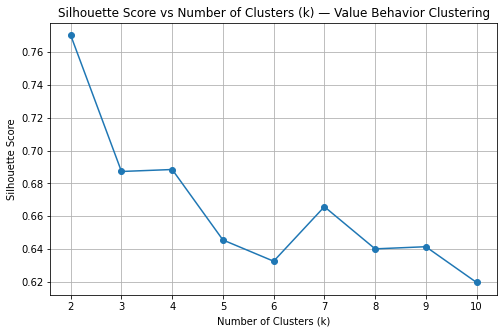

In [0]:
# Plot silhouette score vs k
plt.figure(figsize=(8, 5))
plt.plot(value_behavior_k_values, value_behavior_silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters (k) — Value Behavior Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

##### Apply k-means with chosen k (k=4)

In [0]:
# Final K-Means with k = 4 for value behavior clustering
k = 4
value_behavior_kmeans = KMeans(featuresCol='valueBehaviorScaledFeatures', k=k, seed=42)
value_behavior_kmeans_model = value_behavior_kmeans.fit(value_behavior_df_prepared)
value_behavior_predictions = value_behavior_kmeans_model.transform(value_behavior_df_prepared)

# Prepare for profiling
value_behavior_clusters = value_behavior_predictions
value_behavior_clusters.cache()

# Show cluster sizes
value_behavior_clusters.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  415|
|         1|  948|
|         2|  495|
|         3|  358|
+----------+-----+



##### Promotions usage and online engagement clustering profiling

In [0]:
# Define columns to profile (promotions + engagement)
value_behavior_profile_columns = [
    'Total_Spend',
    'NumTotalPurchases',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'Website_Engagement'
]

# Build aggregation expressions
value_behavior_agg_exprs = [ F.avg(col).alias(f'avg_{col}') for col in value_behavior_profile_columns ]

# Compute cluster profile
value_behavior_profile = value_behavior_clusters.groupBy('prediction').agg(*value_behavior_agg_exprs).orderBy('prediction')

# Convert to pandas for better visualization
value_behavior_profile_pd = value_behavior_profile.toPandas()
pd.options.display.float_format = '{:,.2f}'.format

# Show pandas table
value_behavior_profile_pd

,prediction,avg_Total_Spend,avg_NumTotalPurchases,avg_AcceptedCmp1,avg_AcceptedCmp2,avg_AcceptedCmp3,avg_AcceptedCmp4,avg_AcceptedCmp5,avg_Website_Engagement
0,0,"1,589.89",20.39,0.22,0.05,0.09,0.19,0.31,8.52
1,1,80.11,7.29,0.00,0.00,0.07,0.01,0.00,8.26
2,2,531.43,17.02,0.04,0.01,0.06,0.09,0.02,10.49
3,3,967.80,25.65,0.08,0.01,0.08,0.09,0.06,11.96


#### Clustering Analysis
**Cluster 0** - Very High Value Promo-driven buyers

-> Highest Total_Spend = 1,589

-> High NumPurchases = 20,39

-> Heavy promo users: Cmp5 (0.31), Cmp1 (0.22), Cmp4 (0.19) - very responsive to campaigns

-> Website Engagement average = 8.52

**Cluster 1** - 

-> Very low Total_Spend = 80

-> Low NumPurchases = 7.29

-> No promotions used - all 0 or close to 0

-> Website Engagement = 8.26 , lowest

**Cluster 2**

-> Medium Total_Spend = 531

-> Moderate NumPurchases = 17.02

-> Very low promotions used

**Cluster 3**

-> High NumPurchases = 25.65 ; highest

-> High-moderate Total_Spend = 967

-> Low promo use but not zero, some light engagement

-> Highest Website Engagement = 11.96